# Summary of Allreduce between Nodes

In [1]:
%matplotlib inline
import glob
import os
from pathlib import Path
import re

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SAVE_FIGURE = False
FIGURE_FONT_SIZE = 12

plt.rcParams["figure.dpi"] = 120
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.size'] = FIGURE_FONT_SIZE
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 30)

project_dir = os.getcwd()
dir_anode_results = f'{project_dir}/inter_anode'
dir_vnode_results = f'{project_dir}/inter_vnode'

In [2]:
# function definitions

def read_data_from_file(filepath, name=None):
    if filepath.endswith('nccl'):
        is_nccl_file = True
    else:
        is_nccl_file = False
    lines = []
    with open(filepath) as inf:
        for line in inf:
            line = line.strip()
            if line == '' or line.startswith('#'):
                continue
            if is_nccl_file and line.startswith('['):
                continue
            lines.append(line)

    index = [int(line.split()[0]) for line in lines]
    if is_nccl_file:
        data = [float(line.split()[4]) for line in lines]
    else:
        data = [float(line.split()[1]) for line in lines]
    return pd.Series(data=data, index=index, name=name)

def load_data():
    node_types = {
        'anode': dir_anode_results,
        'vnode': dir_vnode_results
    }
    methods = {
        'mpi-gpu': 'mpi',
        'mpi-cpu': 'mpi-cpu',
        'nccl': 'nccl'
    }
    nnodes = [2, 4, 8, 16, 32]

    series = []
    for method, suffix in methods.items():
        for node, dirpath in node_types.items():
            for nnode in nnodes:
                column_key = f'{method}:{node}:{nnode}'
                file_pattern = f'{dirpath}/job{nnode:02d}.sh.*.{suffix}'
                files = glob.glob(file_pattern)
                if not files:
                    continue
                data = read_data_from_file(files[0], column_key)
                series.append(data)
    return pd.concat(series, axis=1)

def plot(data, column_labels, markers, title, legend_fontsize=None):
    def _xticks_labels():
        idxs = [4, 8, 12, 16, 20, 24]
        xticks = [2**i for i in idxs]
        labels = []
        for val in xticks:
            if val < 1024:
                labels.append(str(val))
            elif val < 1024 * 1024:
                labels.append(str(val // 1024) + 'K')
            else:
                labels.append(str(val // 1024 // 1024) + 'M')
        return xticks, labels

    data0 = data[column_labels.keys()]
    data0 = data0.rename(columns=column_labels)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.set_xlabel('Message Size (Bytes)')
    ax.set_xscale('log', base=2)
    xticks, xticklabels = _xticks_labels()
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)

    ax.set_ylabel('Time (Micro-second)')
    ax.set_yscale('log')

    data0.plot(ax=ax, style=markers)
    ax.legend(fontsize=legend_fontsize)
    if SAVE_FIGURE:
        fig.savefig(f'{title}.pdf')
    ax.set_title(title)

In [3]:
data = load_data()
data

,mpi-gpu:anode:2,mpi-gpu:anode:4,mpi-gpu:anode:8,mpi-gpu:anode:16,mpi-gpu:vnode:2,mpi-gpu:vnode:4,mpi-gpu:vnode:8,mpi-gpu:vnode:16,mpi-gpu:vnode:32,mpi-cpu:anode:2,mpi-cpu:anode:4,mpi-cpu:anode:8,mpi-cpu:anode:16,mpi-cpu:vnode:2,mpi-cpu:vnode:4,mpi-cpu:vnode:8,mpi-cpu:vnode:16,mpi-cpu:vnode:32,nccl:anode:2,nccl:anode:4,nccl:anode:8,nccl:anode:16,nccl:vnode:2,nccl:vnode:4,nccl:vnode:8,nccl:vnode:16,nccl:vnode:32
4,34.31,35.69,36.37,39.20,28.87,29.76,31.94,32.45,36.09,3.35,5.36,7.71,9.27,3.29,4.30,5.76,7.82,10.37,33.50,42.34,57.31,67.85,17.98,31.31,41.36,56.18,63.27
8,34.10,35.38,36.07,39.08,28.97,29.93,31.68,32.08,35.97,3.35,5.34,7.46,9.17,3.26,4.39,5.77,7.55,9.93,32.62,42.03,51.38,61.68,17.93,30.74,40.79,50.38,61.57
16,34.22,34.49,36.66,39.50,29.66,30.24,31.94,32.46,36.62,3.36,5.35,7.43,9.15,3.32,4.33,5.75,7.52,10.29,32.38,42.31,51.35,61.74,17.99,31.06,41.10,50.98,61.91
32,33.00,37.34,36.87,39.07,29.62,28.98,31.32,33.45,36.80,3.66,5.55,7.67,9.56,3.51,4.63,5.99,7.85,10.52,32.40,42.77,51.80,61.99,17.95,31.19,41.26,50.96,61.57
64,36.70,37.03,41.42,70.73,27.70,29.24,30.90,33.36,36.22,4.17,6.02,8.19,9.96,4.01,5.17,6.74,8.42,11.23,33.23,42.99,52.11,62.74,18.28,31.65,41.68,51.33,62.69
128,36.09,38.68,49.12,41.72,28.17,29.94,31.86,34.35,37.47,4.97,6.65,9.07,10.85,4.19,5.44,7.46,8.96,11.79,32.51,43.56,53.20,63.65,18.74,32.29,42.33,52.93,64.99
256,34.40,37.54,39.44,43.98,28.78,31.19,33.22,38.62,39.76,5.32,7.55,10.20,12.39,4.49,6.26,8.61,11.10,13.97,33.96,46.63,55.01,66.15,18.92,32.60,42.78,53.02,64.72
512,35.02,38.09,40.27,43.91,29.28,31.81,34.01,40.30,40.78,5.80,8.11,10.91,12.86,4.77,6.81,9.20,11.45,15.29,34.84,47.58,56.95,68.16,19.81,34.20,44.70,55.39,67.79
1024,36.04,39.23,42.49,44.04,30.50,33.33,35.88,39.73,44.27,6.29,8.89,11.95,14.23,5.47,7.71,10.68,13.08,16.87,36.44,50.20,63.53,74.13,23.33,37.45,49.50,61.77,74.91
2048,38.84,42.64,45.71,48.63,33.50,36.96,39.90,43.53,73.10,8.47,11.55,15.32,17.88,7.49,10.24,13.68,17.15,21.78,37.83,53.70,66.06,76.74,24.37,43.63,57.47,71.49,87.32


## Node(A) vs. Node(V)

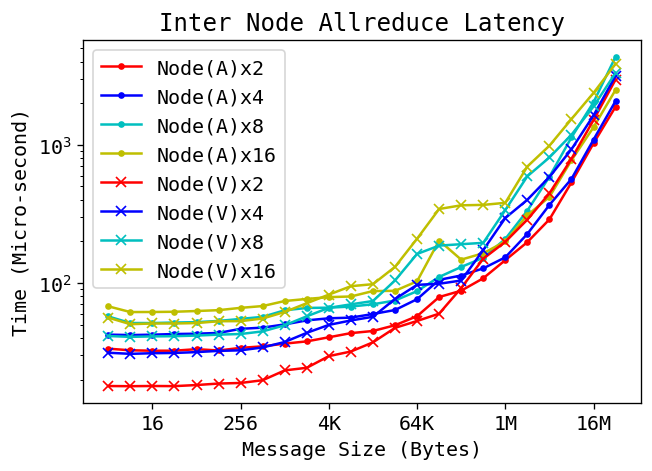

In [4]:
title = 'Inter Node Allreduce Latency'
column_labels = {
    'nccl:anode:2': 'Node(A)x2',
    'nccl:anode:4': 'Node(A)x4',
    'nccl:anode:8': 'Node(A)x8',
    'nccl:anode:16': 'Node(A)x16',
    'nccl:vnode:2': 'Node(V)x2',
    'nccl:vnode:4': 'Node(V)x4',
    'nccl:vnode:8': 'Node(V)x8',
    'nccl:vnode:16': 'Node(V)x16',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

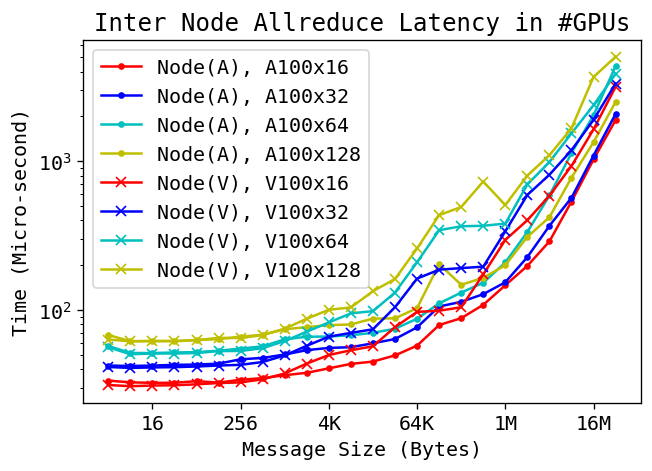

In [5]:
title = 'Inter Node Allreduce Latency in #GPUs'
column_labels = {
    'nccl:anode:2': 'Node(A), A100x16',
    'nccl:anode:4': 'Node(A), A100x32',
    'nccl:anode:8': 'Node(A), A100x64',
    'nccl:anode:16': 'Node(A), A100x128',
    'nccl:vnode:4': 'Node(V), V100x16',
    'nccl:vnode:8': 'Node(V), V100x32',
    'nccl:vnode:16': 'Node(V), V100x64',
    'nccl:vnode:32': 'Node(V), V100x128',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(A)

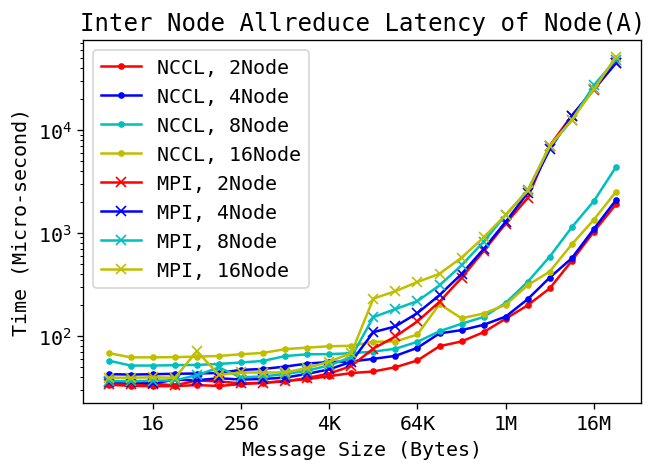

In [6]:
title = 'Inter Node Allreduce Latency of Node(A)'
column_labels = {
    'nccl:anode:2': 'NCCL, 2Node',
    'nccl:anode:4': 'NCCL, 4Node',
    'nccl:anode:8': 'NCCL, 8Node',
    'nccl:anode:16': 'NCCL, 16Node',
    'mpi-gpu:anode:2': 'MPI, 2Node',
    'mpi-gpu:anode:4': 'MPI, 4Node',
    'mpi-gpu:anode:8': 'MPI, 8Node',
    'mpi-gpu:anode:16': 'MPI, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

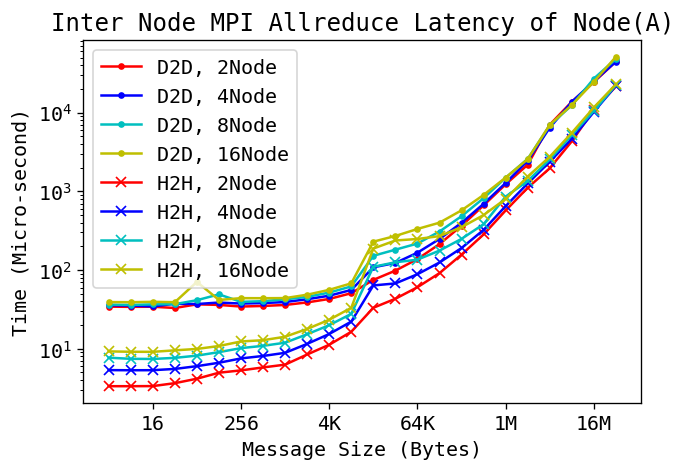

In [7]:
title = 'Inter Node MPI Allreduce Latency of Node(A)'
column_labels = {
    'mpi-gpu:anode:2': 'D2D, 2Node',
    'mpi-gpu:anode:4': 'D2D, 4Node',
    'mpi-gpu:anode:8': 'D2D, 8Node',
    'mpi-gpu:anode:16': 'D2D, 16Node',
    'mpi-cpu:anode:2': 'H2H, 2Node',
    'mpi-cpu:anode:4': 'H2H, 4Node',
    'mpi-cpu:anode:8': 'H2H, 8Node',
    'mpi-cpu:anode:16': 'H2H, 16Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'rx-', 'bx-', 'cx-', 'yx-']
plot(data, column_labels, markers, title)

## Performance Differences by Communication Methods of Node(V)

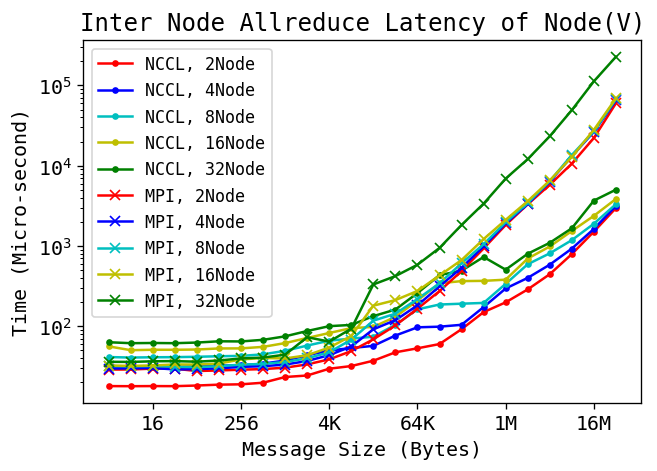

In [8]:
title = 'Inter Node Allreduce Latency of Node(V)'
column_labels = {
    'nccl:vnode:2': 'NCCL, 2Node',
    'nccl:vnode:4': 'NCCL, 4Node',
    'nccl:vnode:8': 'NCCL, 8Node',
    'nccl:vnode:16': 'NCCL, 16Node',
    'nccl:vnode:32': 'NCCL, 32Node',
    'mpi-gpu:vnode:2': 'MPI, 2Node',
    'mpi-gpu:vnode:4': 'MPI, 4Node',
    'mpi-gpu:vnode:8': 'MPI, 8Node',
    'mpi-gpu:vnode:16': 'MPI, 16Node',
    'mpi-gpu:vnode:32': 'MPI, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=10)

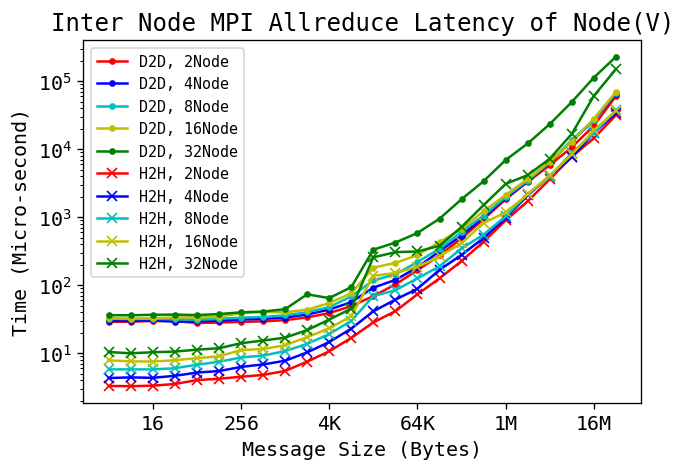

In [9]:
title = 'Inter Node MPI Allreduce Latency of Node(V)'
column_labels = {
    'mpi-gpu:vnode:2': 'D2D, 2Node',
    'mpi-gpu:vnode:4': 'D2D, 4Node',
    'mpi-gpu:vnode:8': 'D2D, 8Node',
    'mpi-gpu:vnode:16': 'D2D, 16Node',
    'mpi-gpu:vnode:32': 'D2D, 32Node',

    'mpi-cpu:vnode:2': 'H2H, 2Node',
    'mpi-cpu:vnode:4': 'H2H, 4Node',
    'mpi-cpu:vnode:8': 'H2H, 8Node',
    'mpi-cpu:vnode:16': 'H2H, 16Node',
    'mpi-cpu:vnode:32': 'H2H, 32Node',
}
markers = ['r.-', 'b.-', 'c.-', 'y.-', 'g.-', 'rx-', 'bx-', 'cx-', 'yx-', 'gx-']
plot(data, column_labels, markers, title, legend_fontsize=9)